# Project 4: Machine Learning - Classification Task

In [54]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import optuna
import re

%matplotlib inline
plt.style.use('seaborn')

In [55]:
# timing the project execution
import time
start_time = time.time()

In [56]:
# fixing RANDOM_SEED
RANDOM_SEED = 42

In [57]:
!pip freeze > requirements.txt

In [58]:
data = pd.read_csv('bank_fin.csv', sep = ';')

## Part 0: Data exploration

In [59]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Data about the bank's clients:

- age (age);
- job (area of employment);
- marital status;
- education (level of education);
- default (whether there is overdue credit);
- housing (whether there is a home loan);
- loan (whether there is credit for personal needs);
- balance.

Data related to the last contact in the context of the current marketing campaign:

- contact (type of customer contact);
- month (month in which the last contact was);
- day (day when the last contact was made);
- duration (duration of the contact in seconds).

Other attributes:

- campaign (number of contacts with this customer during the current campaign);
- pdays (number of days missed from the last marketing campaign to the contact in the current campaign);
- previous (number of contacts before the current campaign)
- poutcome (the result of the last marketing campaign).

The target variable 'deposit', which determines whether the client will agree to open a deposit at the bank. This is what we will try to predict in this case.



In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [61]:
# searching for null values
data.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

>Null values are presented in 'balance' feature.

In [62]:
# searching for another representation of unknown or missing values
data.describe(include=object)

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


> The 'unknown' can be representation of missing values.

In [63]:
data[data == 'unknown'].describe(include=object)

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,70,0,497,0,0,0,0,2346,0,8326,0
unique,1,0,1,0,0,0,0,1,0,1,0
top,unknown,NaN,unknown,NaN,NaN,NaN,NaN,unknown,NaN,unknown,NaN
freq,70,NaN,497,NaN,NaN,NaN,NaN,2346,NaN,8326,NaN


In [64]:
for i in ['job', 'education', 'contact' , 'poutcome']:
    print(data[i].value_counts(), '\n')

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64 

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64 

cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64 

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64 



> Missing values, as 'unknown' are present in 'job', 'education' features.
Value 'unknown' in features 'contact' and 'poutcome' is representet as category.

## Part 1: Data cleansing

### 'job' feature

In [65]:
data['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [66]:
# replacing 'job' feature missing values with modal 
data['job'][data['job'] == 'unknown'] = data['job'].mode()[0]


### 'education' feature

In [67]:
# replacing 'education' feature missing values with modal 
data['education'][data['education'] == 'unknown'] = data['education'].mode()[0]

### Balance feature

In [68]:
data['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

In [69]:
# bringing 'balance' feature to numerical data type
pattern = r',00|\$|\s'
data['balance'] = data['balance'].apply(lambda x: float(re.sub(pattern, '', x)) if type(x) is str else x)

print('Mean value for \'balance\' feature:\n', round(data['balance'].mean(), 3))

Mean value for 'balance' feature:
 1529.129


In [70]:
# replacing 'balance' feature missing values with the median
data['balance'].fillna(data['balance'].median(), inplace=True)
print('Mean value for \'balance\' feature:\n', round(data['balance'].mean(), 3))

Mean value for 'balance' feature:
 1526.936


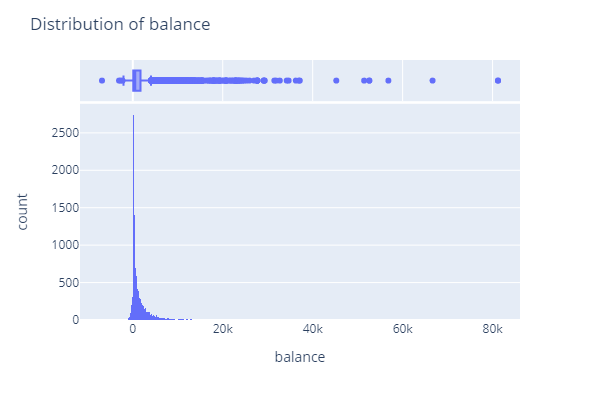

In [71]:
# distribution visualization
def distribution_fig(data, column):
    """Building histogram for distribution visualization.

    Args:
        data (DataFrame):  DataFrame for visualization.
        column (str): feature for visualization.

    Returns:
        fig: histogram for distribution 
    """
    
    # building histogram
    fig = px.histogram(
        data_frame=data,
        x=column,
        title='',
        width=600,
        height=400,
        marginal='box'
    )
    fig.update_layout(title='Distribution of {}'.format(column))
    
    return fig.show('png')

# building a distribution plot for 'balance'
distribution_fig(data, 'balance')

>Large amount of outliers.

In [72]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    """IQR outliers search.
    Finding outliers using the interquartile range (Tukey's range test) 

    Args:
        data (DataFrame): DataFrame for analysis.
        feature (str): numeric column to analyse.
        left (float, optional),  
        right (float, optional): IQRs  the left and right borders.
                                    Defaults to 1.5.
        log_scale (bool, optional): parameter of using logarithmic scale in search.  
                                    Default to False.
    Returns:
        outliers (DataFrame): Outliers
        cleaned  (DataFrame): Cleaned data without outliers.
    """
    
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]

    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>lower_bound) & (x<upper_bound)]
    
    print(f'Count Tukey\'s range outliers for {feature}: {outliers.shape[0]}')
    print(f'Records without outliers for {feature}: {data.shape[0]-outliers.shape[0]}')
    print(f'Boundaries [{lower_bound}:{upper_bound}]')

    return outliers, cleaned

Count Tukey's range outliers for balance: 1057
Records without outliers for balance: 10105
Boundaries [-2241.0:4063.0]


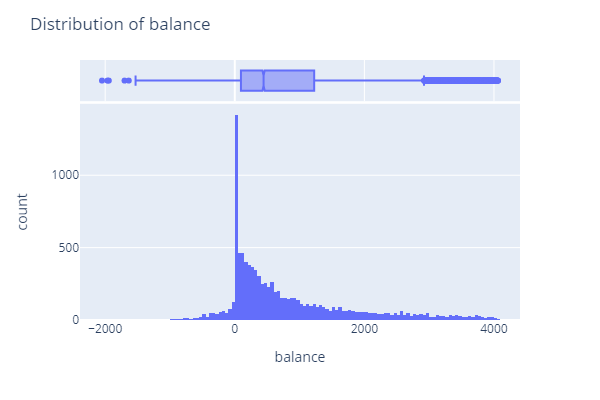

In [73]:
# searching for interquartile range outliers 
outliers_iqr, cleaned_iqr = outliers_iqr_mod(data, 'balance')

# continueing with cleaned data
data = data.drop(index=outliers_iqr.index, axis=0)

# visualization of cleaned reviewer_score with the interquartile range (Tukey's range test) 
distribution_fig(cleaned_iqr, 'balance')


>The distribution is asymmetrical, skewed to right (right-tailed).

## Part 2: Exploratory Data Analysis

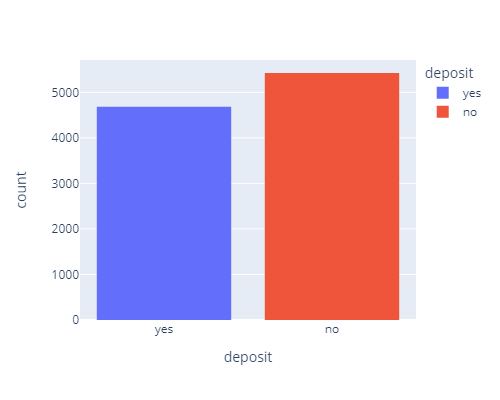

In [74]:
# the ratio of data imbalance
fig = px.histogram(
        data, 
        x='deposit',
        title='',
        width=500,
        height=400,
        color='deposit'
    )

fig.show('png');

>Dataset is slightly disbalanced.

In [75]:
# changing representation of the target feature from no/yes to 0/1
data['deposit'] = data['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [76]:
# defining quantitative and qualitative features

num_features = (data.select_dtypes(include=['number']).columns[:-1])
cat_features = (data.select_dtypes(include=['object']).columns)


print(f'Quantitative features:\n{num_features}\n \nQualitative features:\n{cat_features}')

Quantitative features:
Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')
 
Qualitative features:
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')


### Descriptive statistics for quantitative variables.


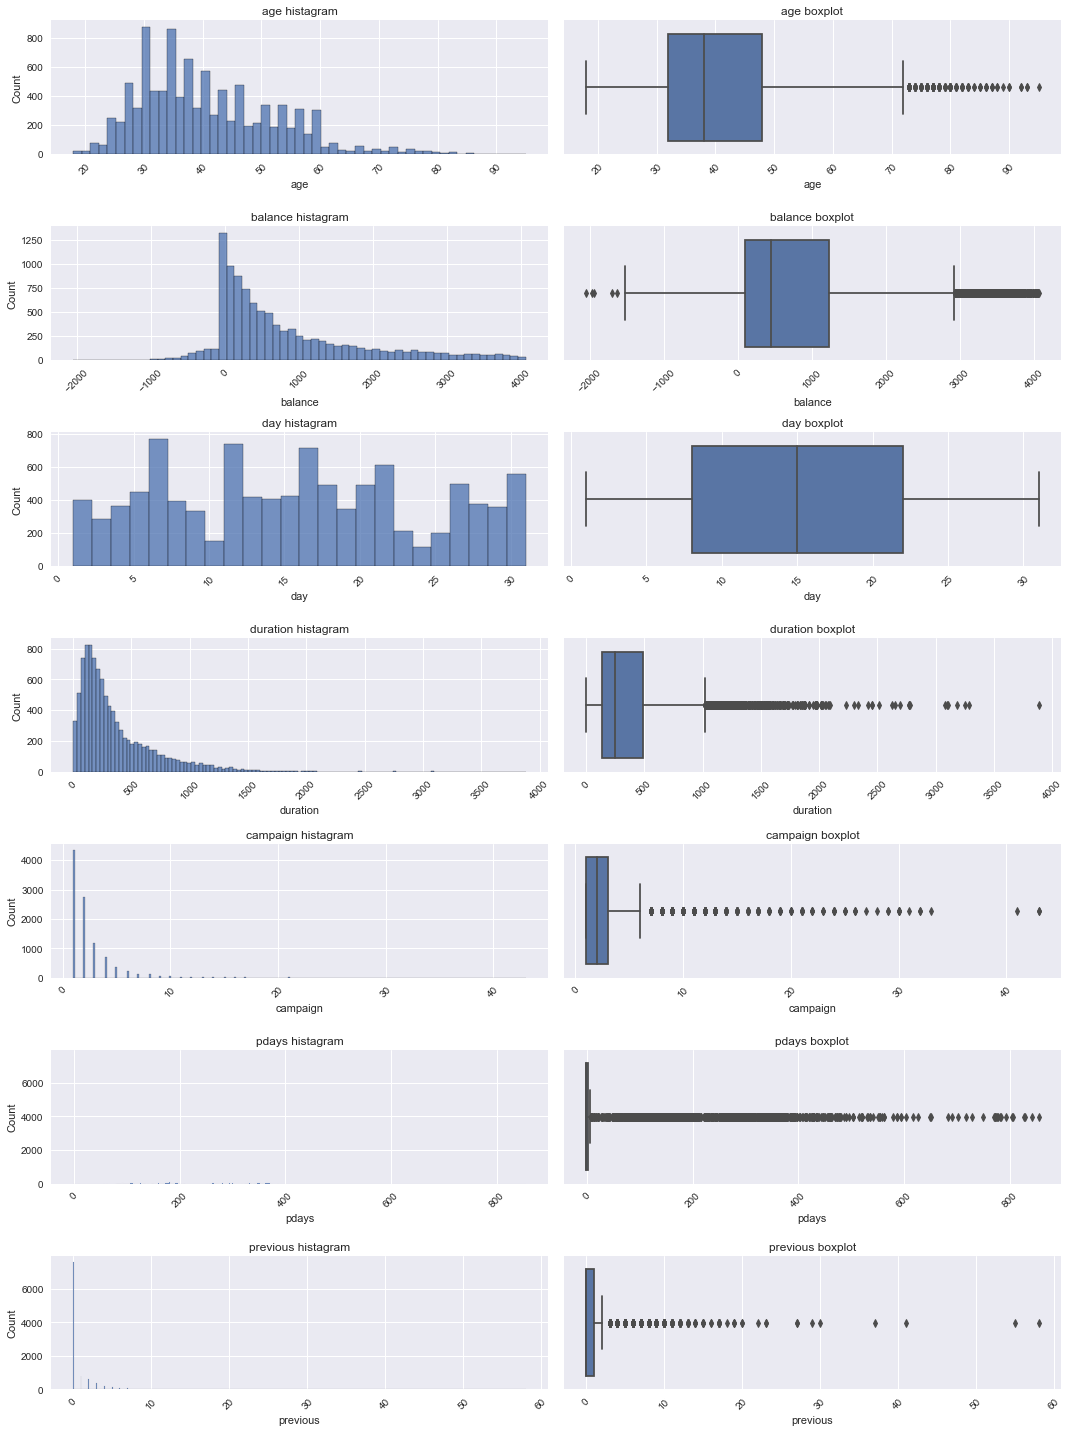

In [77]:
n = len(num_features) # number of numerical features
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # figure + n x 2 coordinate planes
# Loop over all features from numerical features list
for i, feature in enumerate(num_features): # i - index, feature - name of feature in the table
    # Plot histogram of feature distribution
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    # Add title to the plot
    histplot.set_title('{} histagram'.format(feature))
    # Rotate x-axis ticks
    histplot.xaxis.set_tick_params(rotation=45)
    # Plot scatterplot + linear regression
    boxplot = sns.boxplot(data=data, x=feature, ax=axes[i][1])
    # regplot = sns.regplot(data=data, x=feature, y='deposit', ax=axes[i][1])
    # Add title to the plot
    boxplot.set_title('{} boxplot'.format(feature));
    # Rotate x-axis ticks
    boxplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() # align the plots

#### 'age' feature

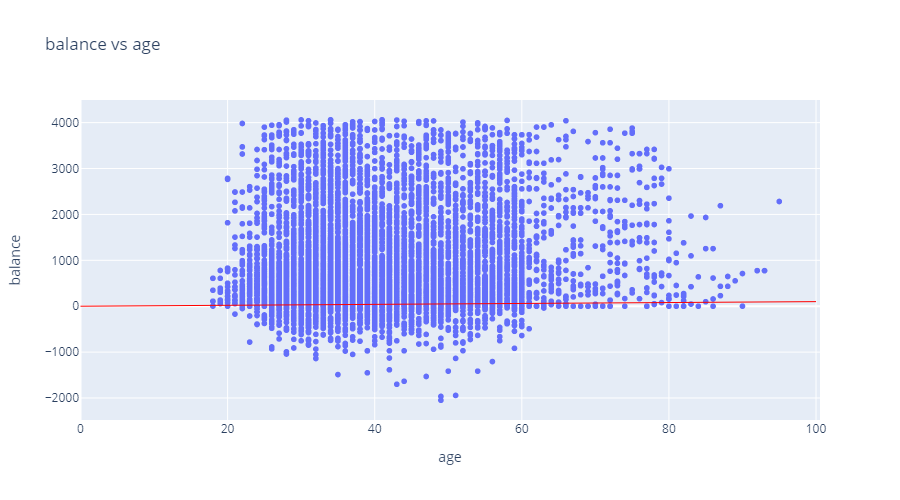

In [78]:
# relation of age and balance

age_exp_data = data.loc[:, ['age', 'balance']]

fig = px.scatter(
    age_exp_data, 
    x='age', 
    y='balance', 
    title='balance vs age',
    width=900,
)
fig.add_shape(type="line",
    x0=0, y0=0, x1=100, y1=100,
    line=dict(
        color="Red",
        width=1
        )
)   
fig.show('png');

> There is no clear dependence of balance on age.

In [79]:
data['age'].describe()

count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

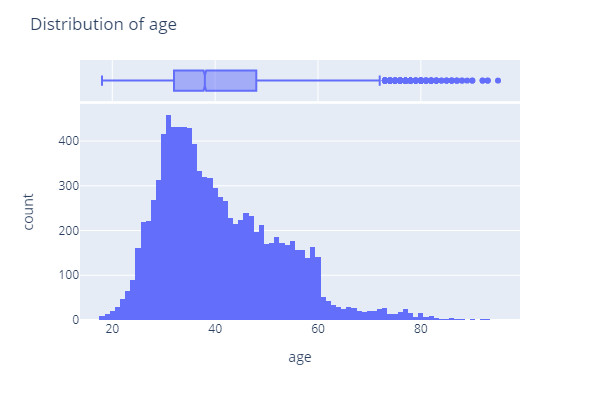

In [80]:
distribution_fig(data, 'age')

>The age distribution is asymmetrical and skewed to the right (right-tailed). There are many outliers that could be removed in a subsequent iteration of the model learning process.

#### 'duration' feature

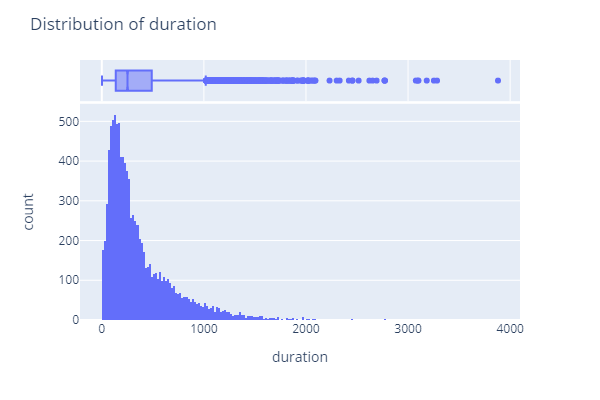

In [81]:
distribution_fig(data, 'duration')

>The distribution of call duration is asymmetrical and skewed to the right, and removing outliers may be worth considering.

In [82]:
data['duration'].describe()

count    10105.000000
mean       368.742603
std        346.651524
min          2.000000
25%        137.000000
50%        252.000000
75%        490.000000
max       3881.000000
Name: duration, dtype: float64

### Descriptive statistics for categorical variables

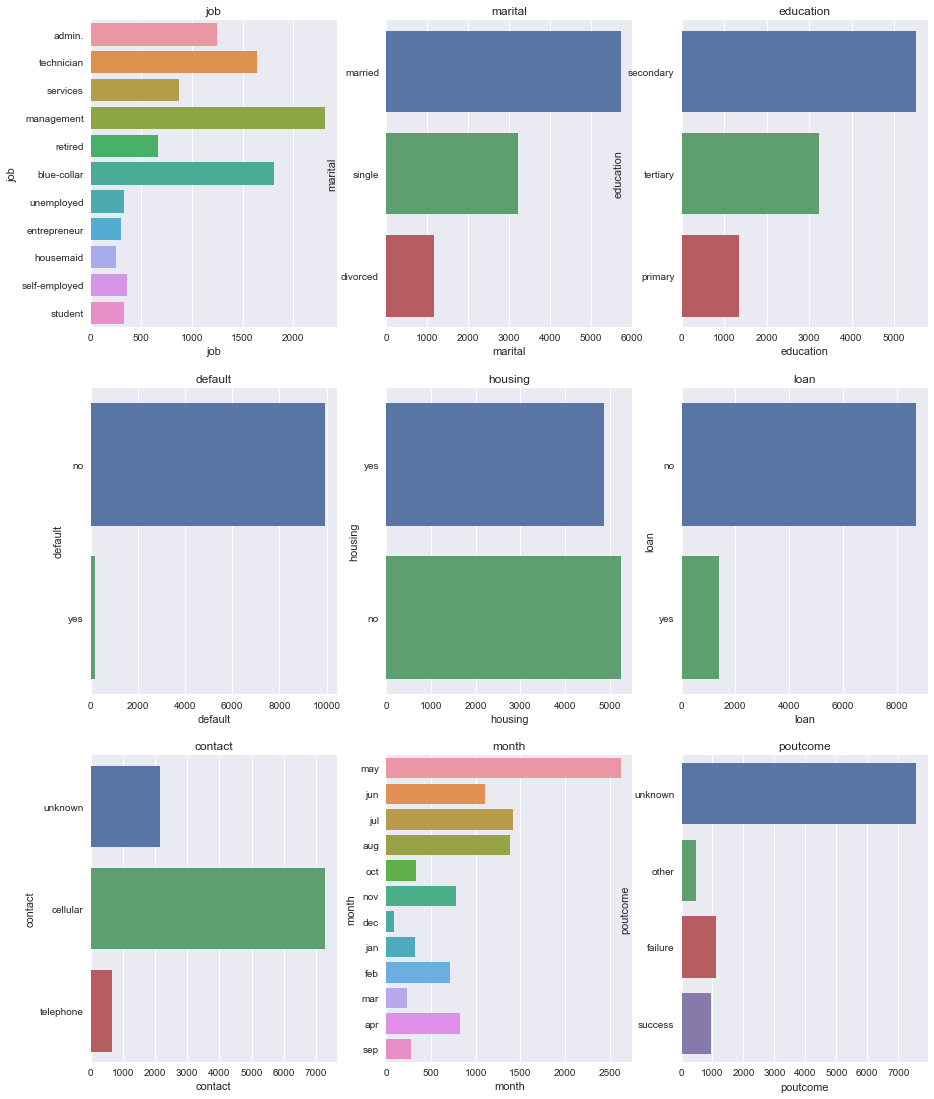

In [83]:

data.describe(include = 'object')
categorical_features=[feature for feature in data.columns if ((data[feature].dtypes=='O') & (feature not in ['deposit']))]
import matplotlib.pyplot as plt
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=data)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

#### 'poutcome' feature

In [84]:
data['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

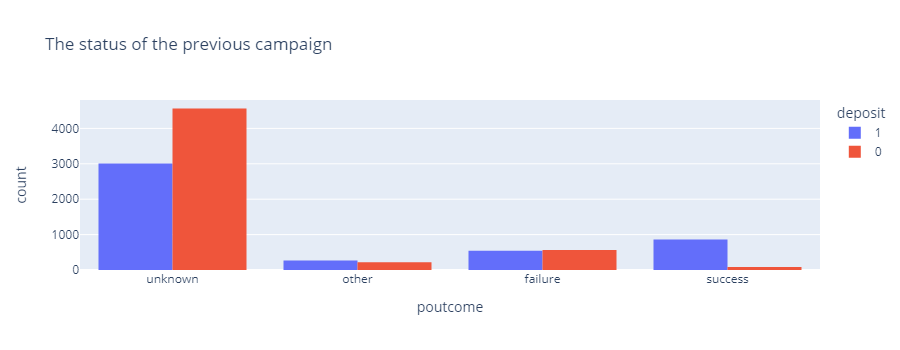

In [85]:
# the difference in the results of the current marketing campaign and the previous one.

fig = px.histogram(
        data, 
        x='poutcome',
        color='deposit',
        barmode="group",
        title='The status of the previous campaign',
        width=900,
        height=350,
)


fig.update_traces(textposition='outside')
fig.show('png');


> Clients who achieved a successful result in the last campaign are more likely to be successful in the current one.

#### 'month' feature

In [86]:
data['month'].value_counts()

may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: month, dtype: int64

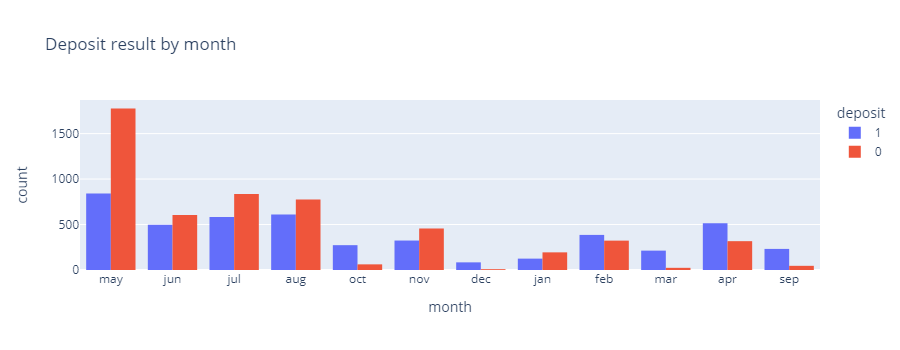

In [87]:
# rejection of the offer to open a deposit by month
fig = px.histogram(
        data, 
        x='month',
        color='deposit',
        barmode="group",
        title='Deposit result by month',
        width=900,
        height=350
)


fig.update_traces(textposition='outside')
fig.show('png');


>The month of May had the highest number of successful results in the previous campaign. March, April, September, October, and December also showed proportionally positive outcomes.

#### 'age' feature

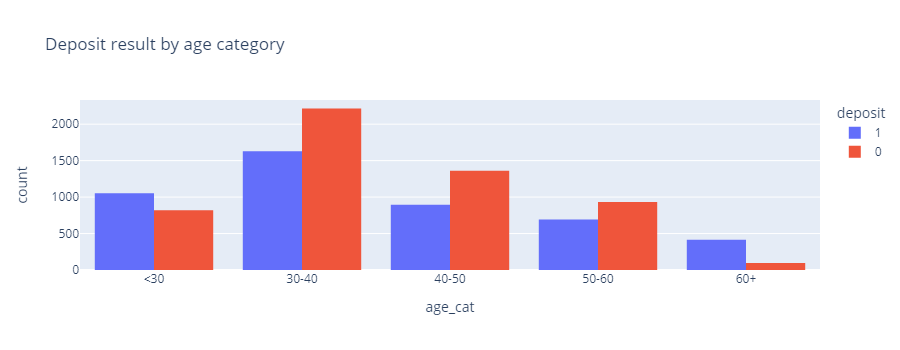

In [88]:
# age groups that are more likely to open a deposit than refuse an offer

data['age_cat'] = pd.cut(data['age'], 
                         bins = [0, 30, 40, 50, 60, 100],
                         labels = ['<30','30-40','40-50','50-60','60+']
)


fig = px.histogram(
        data, 
        x='age_cat',
        color='deposit',
        barmode="group",
        title='Deposit result by age category',
        width=900,
        height=350,
        category_orders= {'age_cat': 
                ['<30','30-40','40-50','50-60','60+']}
)


fig.update_traces(textposition='outside')
fig.show('png');

>Clients under the age of 30 and over 60 are more likely to open a deposit. The age category of 30-40 has the highest number of deposits.

#### 'family' feature

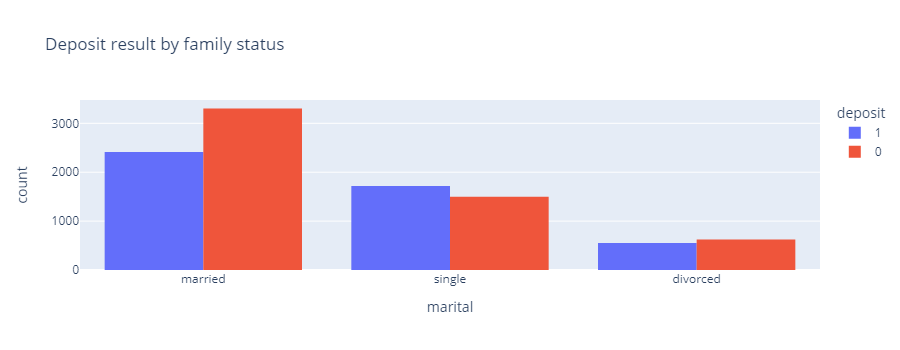

In [89]:
# visualization according to family status
fig = px.histogram(
        data, 
        x='marital',
        color='deposit',
        barmode="group",
        title='Deposit result by family status',
        width=900,
        height=350,

)


fig.update_traces(textposition='outside')
fig.show('png');


>Single clients are more likely to open a deposit, while married have the highest number of deposits.

#### 'education' feature

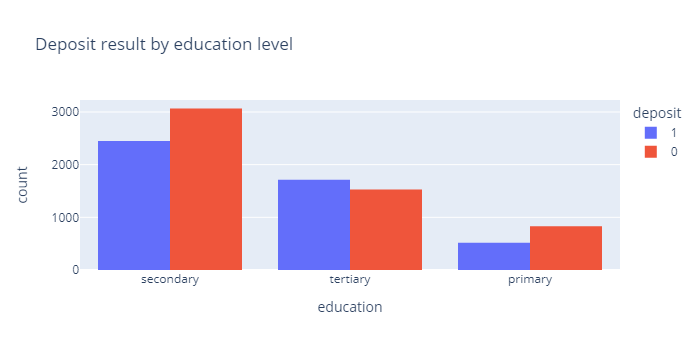

In [90]:
# visualization depending on education
fig = px.histogram(
        data, 
        x='education',
        color='deposit',
        barmode="group",
        title='Deposit result by education level',
        width=700,
        height=350
)


fig.update_traces(textposition='outside')
fig.show('png');


>Clients with tertiary education are more likely to open a deposit, while clients with secondary educaation have the highest number of deposits.

#### 'job' feature

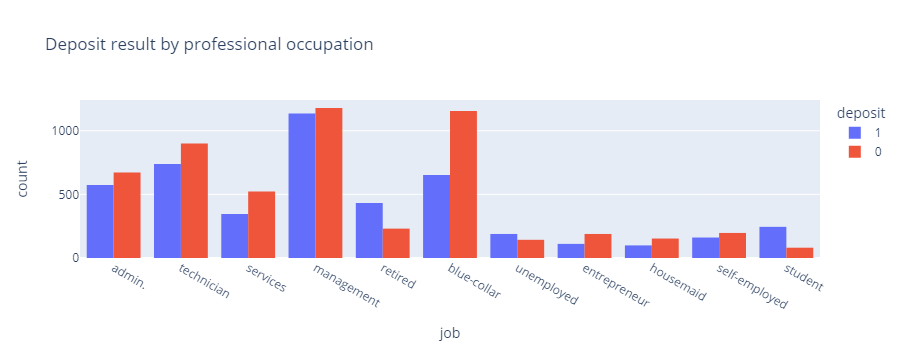

In [91]:
# visualization depending on job
fig = px.histogram(
        data, 
        x='job',
        color='deposit',
        barmode="group",
        title='Deposit result by professional occupation',
        width=900,
        height=350

)


fig.update_traces(textposition='outside')
fig.show('png');


>Clients with job in management have the highest number of deposits.

#### Relationships between different features

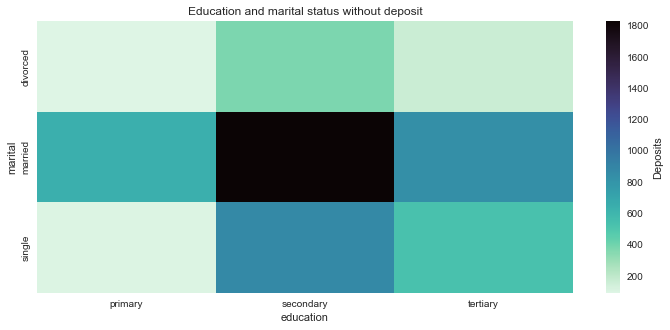

In [92]:
# pivot table to determine education and marital status of clients without deposit
education_marital__pivot = data[data['deposit'] == 0].pivot_table(
    values='deposit',
    columns='education',
    index='marital',
    aggfunc= 'count',
)

fig = plt.figure(figsize=(12, 5))
heatmap = sns.heatmap(
    education_marital__pivot, 
    cmap='mako_r', 
    cbar_kws={'label': 'Deposits'}
)
heatmap.set_title('Education and marital status without deposit');

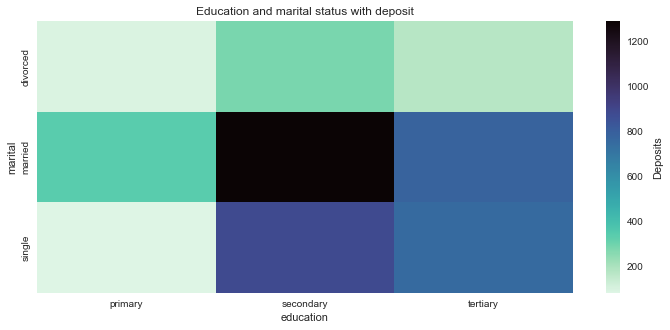

In [93]:
# pivot table to determine education and marital status of clients with deposit
education_marital__pivot = data[data['deposit'] == 1].pivot_table(
    values='deposit',
    columns='education',
    index='marital',
    aggfunc= 'count',
)

fig = plt.figure(figsize=(12, 5))
heatmap = sns.heatmap(
    education_marital__pivot, 
    cmap='mako_r', 
    cbar_kws={'label': 'Deposits'}
)
heatmap.set_title('Education and marital status with deposit');

>Married clients with secondary education have less and more deposits.

## Part 3: Feature Engineering

### Label encodering

In [94]:
# transforming 'education' feature with LabelEncoder
print(f"Features\n {data['education'].value_counts()}")

label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'])

print(f"\nFeatures after encoding\n {data['education'].value_counts()}")

Features
 secondary    5517
tertiary     3239
primary      1349
Name: education, dtype: int64

Features after encoding
 1    5517
2    3239
0    1349
Name: education, dtype: int64


### Converting binary features

In [95]:
# searching for binary features
desc = data.describe(include=object)
binar_features = desc.loc['unique'][desc.loc['unique'] == 2].index

data[binar_features]

,default,housing,loan
0,no,yes,no
1,no,no,no
2,no,yes,no
3,no,yes,no
4,no,no,no
...,...,...,...
11157,no,yes,no
11158,no,no,no
11159,no,no,no
11160,no,no,yes


In [96]:
# transforming to binary representation of 0/1
for f in binar_features:
    data[f] = data[f].apply(lambda x: 1 if x == 'yes' else 0)
    
data[binar_features]

,default,housing,loan
0,0,1,0
1,0,0,0
2,0,1,0
3,0,1,0
4,0,0,0
...,...,...,...
11157,0,1,0
11158,0,0,0
11159,0,0,0
11160,0,0,1


### Converting categorical features

In [97]:
# one-hot encoding with pd.get_dummies
cat = data.select_dtypes(include=['object']).columns
print(cat)

data = pd.get_dummies(data, columns = cat)

Index(['job', 'marital', 'contact', 'month', 'poutcome'], dtype='object')


### Correlation

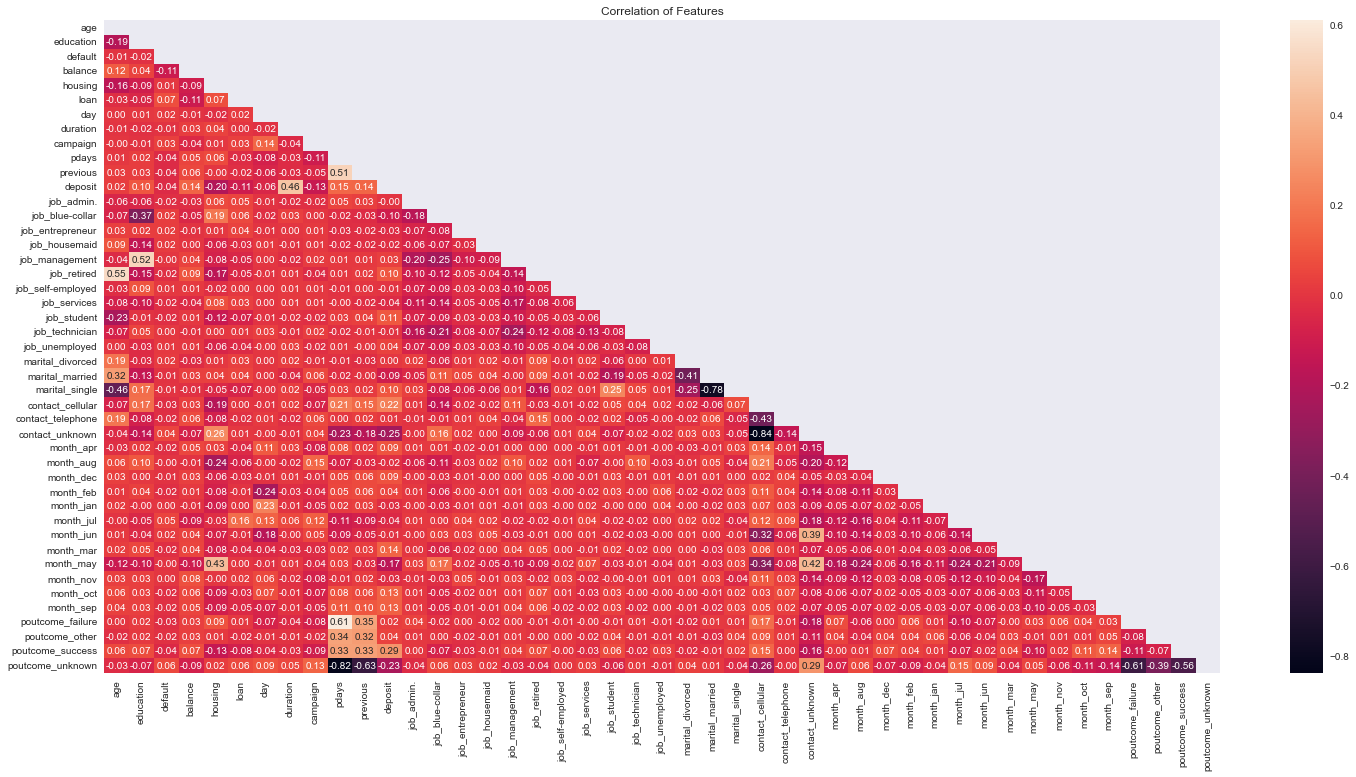

In [98]:
fig = plt.figure(figsize=(25, 12))
corr = data.corr()
mask = np.triu(np.ones_like(corr))
heatmap = sns.heatmap(corr, mask=mask, fmt='.2f', annot=True)
heatmap.set_title('Correlation of Features');

>We have several strong correlations, but nothing critical.

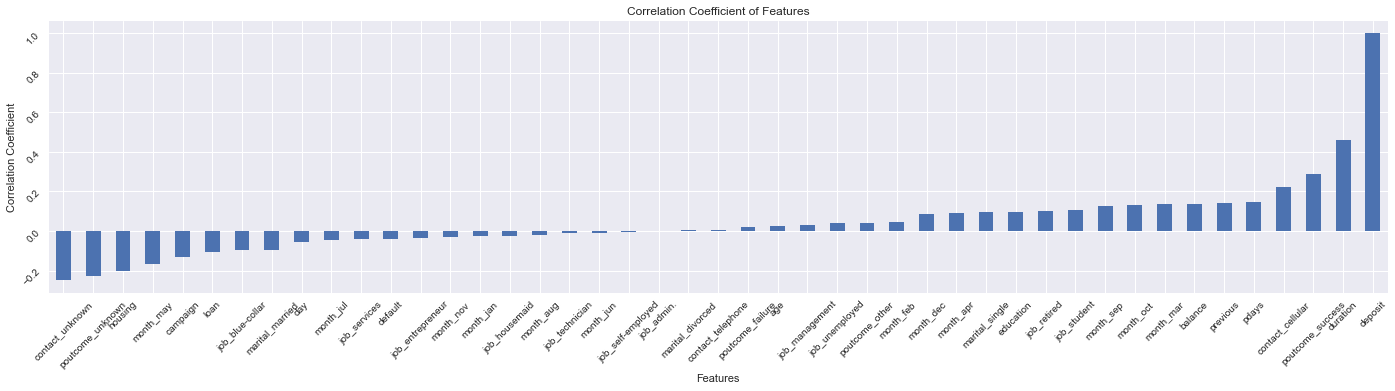

In [99]:
fig = plt.figure(figsize=(24, 5))
corr_values = data.corr()['deposit'].sort_values()
ax = corr_values.plot(kind='bar')
ax.set_xlabel('Features')
ax.set_ylabel('Correlation Coefficient')
ax.tick_params(rotation=45)
plt.title('Correlation Coefficient of Features')
plt.show()

> Call duration, poutcome_success and contact_cellular features have the highest correlation with the target feature, but the correlation is not strong enough to justify their removal.

### Feature selection

In [100]:
# selecting only numeric features
data.drop(data.select_dtypes(exclude=['number']).columns, axis=1, inplace=True)


In [101]:
# splitting data 
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_SEED, test_size=0.33)

In [102]:
# selecting 15 best features using SelectKBest
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
SelectKBest_features = selector.get_feature_names_out()
print(SelectKBest_features)

X_train_best = X_train[SelectKBest_features]
X_test_best = X_test[SelectKBest_features]

['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Normalization

In [103]:
# normalization with MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_best)
X_train_scaled = scaler.transform(X_train_best)
X_test_scaled = scaler.transform(X_test_best)


# Part 4: Solving the Classification Task: LogisticRegression and DecisionTree

### LogisticRegression baseline

In [104]:
%%time
# LogisticRegression baseline
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=RANDOM_SEED,
    max_iter=1000
)

log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
# 0.81


Train Accuracy score: 0.82
Test Accuracy score: 0.80
CPU times: total: 188 ms
Wall time: 355 ms


### DecisionTreeClassifier

In [105]:
%%time
# DecisionTreeClassifier model
dt = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=RANDOM_SEED
)

dt.fit(X_train_scaled, y_train)

y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train Accuracy score: 1.00
Test Accuracy score: 0.75
CPU times: total: 78.1 ms
Wall time: 131 ms


### Hyperparameters search

In [106]:
%%time
# search for max-depth parameter with GridSearchCV
param_grid = {'max_depth': list(range(1, 31))}
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid
)  
grid_search_tree.fit(X_train_scaled, y_train) 
y_test_pred = grid_search_tree.predict(X_test_scaled)


print("Test Accuracy score:: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search_tree.best_params_))

Test Accuracy score:: 0.80
Best parameters: {'max_depth': 6}
CPU times: total: 4.47 s
Wall time: 5.54 s


In [107]:
%%time
# search for max-depth and min_samples_leaf parameters with GridSearchCV
param_grid = {'min_samples_leaf': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid
)  
grid_search_tree.fit(X_train_scaled, y_train) 
y_test_pred = grid_search_tree.predict(X_test_scaled)

print("Test Accuracy score:: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(grid_search_tree.best_params_))

Test Accuracy score:: 0.79
Best parameters: {'max_depth': 7, 'min_samples_leaf': 10}
CPU times: total: 1.06 s
Wall time: 1.14 s


# Part 5: Solving the Classification Task: Ensembles and Prediction

### RandomForestClassifier

In [108]:
%%time
# RandomForestClassifier model
rf = ensemble.RandomForestClassifier(n_estimators=100,
                                     criterion='gini',
                                     min_samples_leaf=5,
                                     max_depth=10,
                                     random_state=RANDOM_SEED
                                     )
rf.fit(X_train_scaled, y_train)

y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train Accuracy score: 0.85
Train Recall score: 0.86
Test Accuracy score: 0.83
Test Recall score: 0.83
CPU times: total: 938 ms
Wall time: 995 ms


In [109]:
%%time
# GradientBoostingClassifier model
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    max_depth=5,
    min_samples_leaf=5,
    random_state=RANDOM_SEED
)

gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train Accuracy score: 0.88
Train Recall score: 0.89
Test Accuracy score: 0.82
Test Recall score: 0.83
CPU times: total: 5.61 s
Wall time: 6.62 s


>RandomForestClassifier model showing better results

### Stacking ensemble model

In [110]:
%%time
# stacking ensemble model based on previous used models
estimators = [
('dt', tree.DecisionTreeClassifier(criterion='entropy',
                                    random_state=42,
                                    max_depth=6)),
('rf', ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion='gini',
                                        min_samples_leaf=5,
                                        max_depth=10,
                                        random_state=42)),
('gb', ensemble.GradientBoostingClassifier(min_samples_leaf=5,
                                        learning_rate=0.05, 
                                        n_estimators=300, 
                                        max_depth=5, random_state=42))

]
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42))

reg.fit(X_train_scaled, y_train)

y_test_pred = reg.predict(X_test_scaled)


print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))


Train Accuracy score: 0.88
Train Recall score: 0.89
Test Accuracy score: 0.83
Test Recall score: 0.83
CPU times: total: 32.2 s
Wall time: 35.6 s


>The stacking ensemble model showing overfitting

### Feature importance overview

In [111]:
X_train_best.columns[[3, 13, 8]]

Index(['duration', 'poutcome_success', 'contact_unknown'], dtype='object')

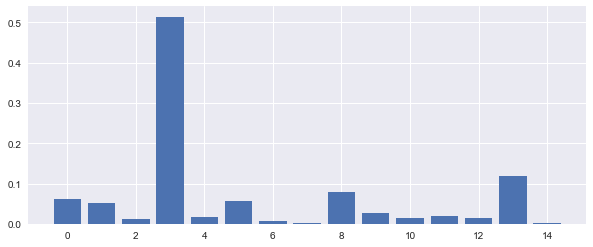

In [112]:
importance = gb.feature_importances_
# for i,v in enumerate(importance):
#   print('Feature: %0d, Score: %.5f' % (i,v))
plt.figure(figsize=(10, 4))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

> Features duration, poutcome_success contact_unknown are  most important for prediction.

### Optimizing hyperparameters with Optuna

In [113]:
%%time
import optuna

def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)
    
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train,  model.predict(X_train_scaled))
    
    return score


study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=20)


print("Best hyperparameters {}".format(study.best_params))
print("Train f1_score: {:.2f}".format(study.best_value))


model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('Test f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-03-15 13:52:16,415] A new study created in memory with name: RandomForestClassifier
[I 2023-03-15 13:52:17,995] Trial 0 finished with value: 0.8623538581449727 and parameters: {'n_estimators': 121, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8623538581449727.
[I 2023-03-15 13:52:19,994] Trial 1 finished with value: 0.8454573837027787 and parameters: {'n_estimators': 111, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8623538581449727.
[I 2023-03-15 13:52:21,697] Trial 2 finished with value: 0.8648396138274681 and parameters: {'n_estimators': 109, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8648396138274681.
[I 2023-03-15 13:52:23,713] Trial 3 finished with value: 0.8737712591667967 and parameters: {'n_estimators': 176, 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8737712591667967.
[I 2023-03-15 13:52:24,699] Trial 4 finished with value: 0.8386194029850746 and parameters: {'n_

Best hyperparameters {'n_estimators': 190, 'max_depth': 27, 'min_samples_leaf': 2}
Train f1_score: 0.92
Test f1_score: 0.81
CPU times: total: 34 s
Wall time: 39.4 s


In [114]:
print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train Accuracy score: 0.93
Train Recall score: 0.93
Test Accuracy score: 0.82
Test Recall score: 0.83


In [115]:
%%time
model = ensemble.RandomForestClassifier(n_estimators=188,
                                        max_depth=28,
                                        min_samples_leaf=10,
                                        random_state=42)
# model = ensemble.RandomForestClassifier(n_estimators=188,
#                                         max_depth=28,
#                                         min_samples_leaf=10,
#                                         random_state=42)
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train Accuracy score: 0.85
Train Recall score: 0.86
Test Accuracy score: 0.83
Test Recall score: 0.83
CPU times: total: 2.41 s
Wall time: 3.25 s


In [116]:
%%time
# stacking ensemble model based on previous used models
estimators = [
('dt', tree.DecisionTreeClassifier(criterion='entropy',
                                    random_state=42,
                                    max_depth=6)),
('rf', ensemble.RandomForestClassifier(**study.best_params,
                                       random_state=42)),
('gb', ensemble.GradientBoostingClassifier(min_samples_leaf=5,
                                        learning_rate=0.05, 
                                        n_estimators=300, 
                                        max_depth=5, 
                                        random_state=42))

]
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42))

reg.fit(X_train_scaled, y_train)

y_test_pred = reg.predict(X_test_scaled)


print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train Accuracy score: 0.85
Train Recall score: 0.86
Test Accuracy score: 0.82
Test Recall score: 0.82
CPU times: total: 45 s
Wall time: 53 s


In [117]:
%%time

estimators = [
('dt', tree.DecisionTreeClassifier(criterion='entropy',
                                    random_state=42,
                                    max_depth=6)),
('rf', ensemble.RandomForestClassifier(n_estimators=188,
                                        criterion='gini',
                                        min_samples_leaf=10,
                                        max_depth=28,
                                        random_state=42)),
('gb', ensemble.GradientBoostingClassifier(min_samples_leaf=5,
                                        learning_rate=0.05, 
                                        n_estimators=300, 
                                        max_depth=5, 
                                        random_state=42))

]
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42))

reg.fit(X_train_scaled, y_train)

y_test_pred = reg.predict(X_test_scaled)


print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))


Train Accuracy score: 0.85
Train Recall score: 0.86
Test Accuracy score: 0.83
Test Recall score: 0.83
CPU times: total: 33.1 s
Wall time: 33.4 s


In [118]:
%%time
# best model
estimators = [
('dt', tree.DecisionTreeClassifier(criterion='entropy',
                                    random_state=42,
                                    max_depth=6)),
('rf', ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion='gini',
                                        min_samples_leaf=5,
                                        max_depth=10,
                                        random_state=42)),
('gb', ensemble.GradientBoostingClassifier(min_samples_leaf=5,
                                        learning_rate=0.05, 
                                        n_estimators=300, 
                                        max_depth=5, random_state=42))

]
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42))

reg.fit(X_train_scaled, y_train)

y_test_pred = reg.predict(X_test_scaled)


print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))


Train Accuracy score: 0.85
Train Recall score: 0.86
Test Accuracy score: 0.83
Test Recall score: 0.83
CPU times: total: 37.4 s
Wall time: 49.1 s


In [119]:
end_time = time.time()
minutes, seconds = divmod(end_time - start_time, 60)
print(f"Runtime: {minutes:.0f} min {seconds:.0f} sec")


Runtime: 5 min 6 sec


# Conclusions

Best score:
* Train Accuracy score: 0.85
* Train Recall score: 0.86
* Test Accuracy score: 0.83
* Test Recall score: 0.83


In this project, a full range of assignments was conducted on a real Data Science case. I completed data exploration and cleansing by removing outliers and null values. For Exploratory Data Analysis, I used descriptive statistics for both quantitative and qualitative variables. During the feature engineering phase, I encoded and converted features. After checking for correlation, I normalized and selected the most valuable features. I created several models to achieve the best results by searching for hyperparameters. The best result in metrics was obtained by using a Stacking ensemble based on a Decision Tree Classifier, Random Forest Classifier, and Gradient Boosting Classifier with Logistic Regression as the final estimator.